In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_Transformer_real_particles import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText
import math

In [2]:
#GPU
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_layers, p, neg_slope, n_head, pos_dropout):
        super(Transformer, self).__init__()

        self.dmodel = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head, dim_feedforward = 2048, dropout = 0.25, batch_first = False, dtype = torch.float)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = self.encoder_layer, num_layers = num_layers)
        self.pos_encoder = PositionalEncoding(d_model = d_model, dropout = pos_dropout)
        
        self.linear = nn.Linear(3, d_model)
        
        self.fcff = nn.Sequential(
          
            nn.Linear(512, 1200, device = device),
            nn.BatchNorm1d(1200),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),
            
            nn.Linear(1200, 450, device = device),
            nn.BatchNorm1d(450),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(450, 30, device = device),
            nn.BatchNorm1d(30),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(30, 3,  device = device),
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)
        
    
    def forward(self, x1, x2):

        x1 = x1.permute(1, 0, 2)
        x1 = self.linear(x1)
        x1 = self.pos_encoder(x1 * torch.sqrt(torch.tensor(self.dmodel)))
        x1 = self.transformer_encoder(x1)
        x1 = x1.permute(1, 0, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fcff(x1)

        x2 = x2.permute(1, 0, 2)
        x2 = self.linear(x2)
        x2 = self.pos_encoder(x2 * torch.sqrt(torch.tensor(self.dmodel)))
        x2 = self.transformer_encoder(x2)
        x2 = x2.permute(1, 0, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fcff(x2)
        
        return torch.stack([x1, x2])

In [5]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, E, ALPHA):
        
        xw, yw = torch.nonzero(W, as_tuple = True)
        
        W = W[xw,yw]
        E = E[xw,yw]

        # loss = torch.mean(torch.abs(E-W)/W)
        # loss = torch.mean((torch.abs(E-W)/W) + ((torch.abs(E-W)/(E + 7e-3))))
        loss = torch.mean(ALPHA * (torch.abs(E-W)/W) + (1 - ALPHA) * (torch.abs(E-W)/(E + 2e-2)))

        return loss


In [6]:
def Reg_Loss(loss, LAMBDA, SIGMA, dist):
    
    l_reg = 0
    for W in model.parameters():
        l_reg = l_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l_reg + SIGMA/torch.sum(dist)
    
    return loss_reg

In [7]:
def classes_reg(dist, targets):
    
    reg = 0
    
    for clas in [1,2,3,4]:
        ind = torch.tensor(list(itertools.combinations_with_replacement(torch.nonzero(targets == clas)[:,0],2)))
        dist = dist.to('cpu')
        reg = reg + torch.sum(dist[ind[:,0],ind[:,1]])
                
    return reg

In [8]:
def Reg_Loss(loss, LAMBDA, SIGMA, dist, targets):
    
    l_reg = 0
    for W in model.parameters():
        l_reg = l_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l_reg + SIGMA/classes_reg(dist, targets)
    
    return loss_reg

In [9]:
def Dist(W, E):
    
    x, y = torch.nonzero(W, as_tuple = True)
    
    W = W[x,y]
    E = E[x,y]
    
    dist = E/W
    
    return dist

In [10]:
def Train(train, W_dist_train, ALPHA):
    train_losses = []
    
    for batch_x in range (n_batches_train):
        for batch_y in range (n_batches_train):
            if torch.count_nonzero(W_dist_train[batch_x][batch_y]) != 0:
                
                sample_emb_train = model(train[batch_x], train[batch_y]).to(device)
                E_dist_train = torch.cdist(sample_emb_train[0], sample_emb_train[1], p = 2).to(device) 

                loss = criterion(W_dist_train[batch_x][batch_y], E_dist_train, ALPHA)
                # dist = Dist(W_dist_train[batch_x][batch_y], E_dist_train)
                # loss_reg = Reg_Loss(loss, LAMBDA, SIGMA, E_dist_train, targest)
                train_losses.append(loss.item())

                optimizer.zero_grad()
                loss.requires_grad_()
                loss.backward(retain_graph=True)

                optimizer.step()
    return train_losses

In [11]:
def Validation(validaiton, W_dist_validation):
    
    sample_emb_validation = model(validation, validation).to(device)
    E_dist_validation = torch.cdist(sample_emb_validation[0], sample_emb_validation[0], p = 2).to(device)
    valid_loss = criterion(W_dist_validation, E_dist_validation)
    
    return valid_loss


In [13]:
def Test(test, W_dist_test, ALPHA):
    
    sample_emb_test = model(test, test).to(device)
    E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p = 2).to(device)
    # test_loss = criterion(W_dist_test, E_dist_test, ALPHA)
    test_dist = Dist(W_dist_test, E_dist_test)

    median_test = torch.median(test_dist)
    
    fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

    ax3_test.set_title('Test set', fontsize = 30)
    ax3_test.set_xlim([-0.1,2])
    ax3_test.set_xlabel("Distortion", fontsize = 20)
    ax3_test.set_ylabel("Density", fontsize = 20)
    ax3_test.tick_params(axis='both', which='major', labelsize=15)
    labels = ['Ideal']

    count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True, edgecolor = 'b')
    ax3_test.axvline(x=1, color='r', linestyle='dashed')

    ax3_test.legend(labels, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax3_test.transAxes)
    anchored_text_test = AnchoredText('Median:'+str('%.2f' % median_test.item()), loc='upper right', bbox_to_anchor = (0.99,0.93), bbox_transform=ax3_test.transAxes)
    ax3_test.add_artist(anchored_text_test)
    
    # fig3.savefig('/home/gabrieleb/Plot/Jets/Real/Transformer_real_particles.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    
    return sample_emb_test


In [28]:
#Dataloder
device = 'cuda'
train, _ = torch.load('/data/gabrieleb/data/Jets/dataset_train_real', map_location=device)
validation, _  = torch.load('/data/gabrieleb/data/Jets/dataset_validation_real', map_location=device)

W_dist_train, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_train_real_s=12000', map_location=device)
W_dist_validation, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_validation_real_s=2400', map_location=device)

train = train.to(torch.float)
validation = validation.to(torch.float)

#parameters

n_sample_train = train.size(0)
batch_size = 300
n_batches_train = int(n_sample_train/batch_size)

train = torch.stack(torch.chunk(train, n_batches_train, dim = 0), dim = 0)
W_dist_train = torch.stack(torch.chunk(torch.stack(torch.chunk(W_dist_train, n_batches_train, dim = -1), dim = 0), n_batches_train, dim = 1), dim = 0)

d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-3

criterion = MyLoss()
#criterion = nn.MSELoss()

LAMBDA = 0
SIGMA = 0

patience = 30
iteration = 1000
neg_slope = 1e-2
p = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)
optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.5)
early_stopping = EarlyStopping(patience = patience, verbose = True)

fig = plt.figure(figsize = (14, 7), constrained_layout=False)
gs = GridSpec(1, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

#ax5 = fig.add_subplot(gs[0, 0])
#ax5.set_title('Distortion validation')
#ax5.set_ylabel('Distortion')
#ax5.axvline(x=1, color='r', linestyle='-')
#ax5.set_xlim(-0.1, 4)
#ax5.set_ylim(-0.1, 0.5)

#fig.suptitle("MNIST and lr= "+str(learning_rate)+'p value is:'+str(p)+'la loss é:MyLoss')

for ite in range (iteration):
    #Train
    model.train()
    train_losses = Train(train, W_dist_train, LAMBDA, SIGMA)
    train_loss = np.average(train_losses)
    ax3.scatter(ite, train_loss, color = 'b', s = 5)

    #Validation
    model.eval()
    valid_loss = Validation(validation, W_dist_validation)
    ax4.scatter(ite, valid_loss.cpu().detach().numpy(), color = 'b', s = 5)

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.07 GiB (GPU 0; 22.16 GiB total capacity; 14.08 GiB already allocated; 465.88 MiB free; 16.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
dist = []

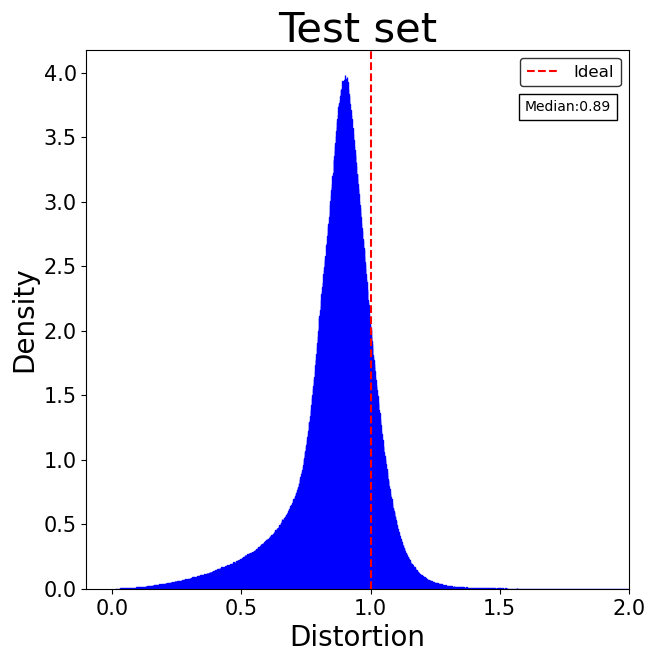

In [14]:
device = 'cpu'
test, _ = torch.load('/data/gabrieleb/data/Jets/dataset_test_real', map_location = device)
W_dist_test, targets_test = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_test_real_s=4000', map_location = device)

test = test.to(torch.float)

criterion = MyLoss()

neg_slope = 1e-2
p = 0.1
d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

ALPHA = 0.6

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)
model.load_state_dict(torch.load('/home/gabrieleb/Checkpoint/checkpoint_transformer_real_sim_3D.pth', map_location = device))

model.eval()

sample_emb_test = Test(test, W_dist_test, ALPHA)
# dist.append(Test(test, W_dist_test, ALPHA))
#val = Test(test, W_dist_test, ALPHA)
#dist.insert(1,val)

In [69]:
torch.save(dist, '/data/gabrieleb/data/Jets/dist_real_multi_(orig,0.2,0.2_3D,0.2_4D)')

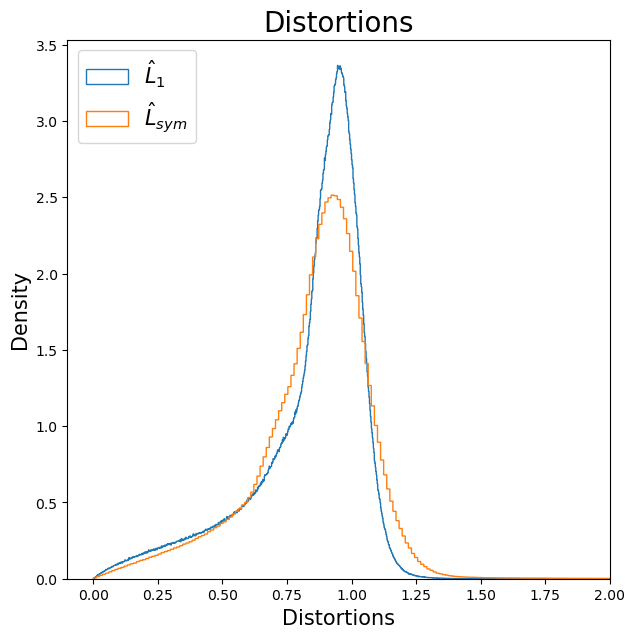

In [18]:
colors = ['b', 'g', 'r','c','m','y','k']
label = ['$\hat{L}_1$', '$\hat{L}_{sym}$', '0.2', '0.2_3D', '0.2_4D', '0.4', '0.5']

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_title('Distortions', fontsize = 20)
ax.set_xlabel('Distortions', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.set_xlim([-0.1, 2])
# ax.set_ylim([0,0.8])

for i in [0,1]:
    
    n, bins, patch = ax.hist(dist[i].detach().numpy(), bins = 1200, density = True, fill = False, label = label[i], histtype='step')
ax.legend(loc = 'upper left', fontsize = 15)
fig.savefig('/home/gabrieleb/Plot/Jets/Real/Distortion_real_sim.pdf')


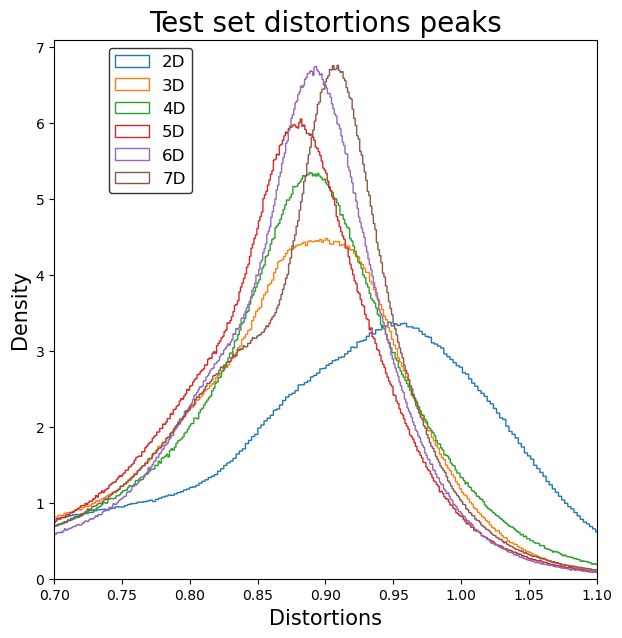

In [16]:
dist = torch.load('/data/gabrieleb/data/Jets/dist_real_multi_2-7', map_location = device)
# dist = torch.load('/data/gabrieleb/data/Jets/dist_real_multi_alpha_(0.1-0.5)', map_location = device)
# dist = torch.load('/data/gabrieleb/data/Jets/dist_real_multi_(orig,0.2,0.2_3D,0.2_4D)', map_location = device)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_xlim([0.7, 1.1])
# ax.set_ylim([0,1])
ax.set_title('Test set distortions peaks', fontsize = 20)
ax.set_xlabel('Distortions', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)

colors = ['b', 'g', 'r','c','m','y','k']
for i in range(len(dist)):
    # fig, ax = plt.subplots(1,1, figsize=(7,7))
    # ax.set_xlim([-0.1, 2])
    # # ax.set_ylim([0,1])
    # ax.set_title('Test set distortion', fontsize = 20)
    # ax.set_xlabel('Distortions', fontsize = 15)
    # ax.set_ylabel('Density', fontsize = 15)

    # ax.hist(dist[0].detach().numpy(), bins = 'auto', density = True, fill = False, label = '$\hat{L}_1$', histtype='step')
    # ax.hist(dist[1].detach().numpy(), bins = 'auto', density = True, fill = False, label = '$\hat{L}_{sym}^{0.2}$', histtype='step')
    # ax.hist(dist[i].detach().numpy(), bins = 'auto', density = True, fill = False, label = '$\hat{L}_{sym}^{0.'+str(i)+'}$', histtype='step')
    # ax.hist(dist[i].detach().numpy(), bins = 'auto', density = True, fill = False, label = '$\hat{L}_{sym}^{0.2}, 3D$', histtype='step')
    ax.hist(dist[i].detach().numpy(), bins = 'auto', density = True, fill = False, label = str(i+2)+'D', histtype='step')
    ax.legend(fontsize = 12, edgecolor = 'black',  bbox_to_anchor = (0.27, 1), bbox_transform = ax.transAxes)
    # fig.savefig(f'/home/gabrieleb/Plot/Jets/Real/Distortions_notsim_{i+1}D.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    # fig.savefig(f'/home/gabrieleb/Plot/Jets/Real/Distortions_0.2_{i+1}D.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    # fig.savefig(f'/home/gabrieleb/Plot/Jets/Real/Distortions_alpha=0.'+str(i)+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    fig.savefig(f'/home/gabrieleb/Plot/Jets/Real/Distortions_peaks.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [23]:
E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p=2)

for prongx in [1,2,3,4]:
    for prongy in [1,2,3,4]:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.set_title(f'Test set {prongx}-{prongy}', fontsize = 30)
        subW = torch.zeros(torch.count_nonzero(targets_test == prongx).item(), torch.count_nonzero(targets_test == prongy).item())
        subE = torch.zeros(torch.count_nonzero(targets_test == prongx).item(), torch.count_nonzero(targets_test == prongy).item())

        l = 0
        for i in torch.nonzero(targets_test == prongx)[:,0]:
            m = 0
            for j in torch.nonzero(targets_test == prongy)[:,0]:
                subW[l][m] = W_dist_test[i][j]
                subE[l][m] = E_dist_test[i][j]
                m = m+1
            l = l+1

        dist = Dist(subW, subE)
        ax.hist(dist.detach().numpy(), bins = 'auto', color = 'b', density = True)

In [13]:
# fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer_3D.pdf', facecolor='w',pad_inches=0.3, transparent=True)

NameError: name 'fig3' is not defined

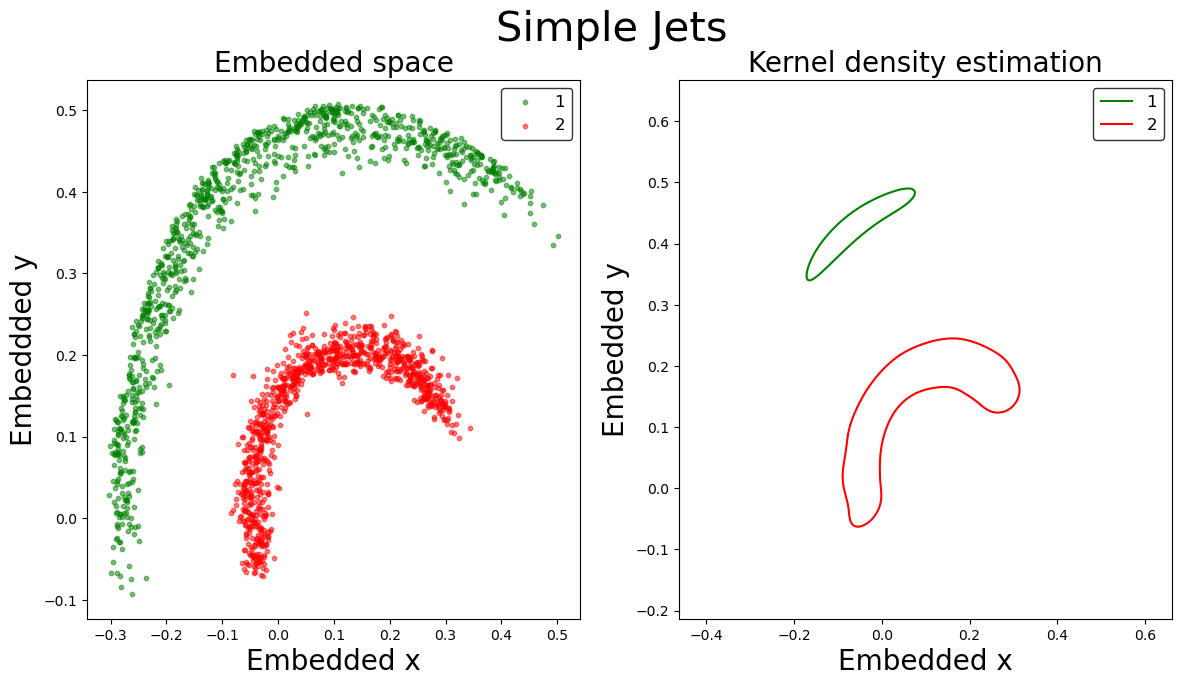

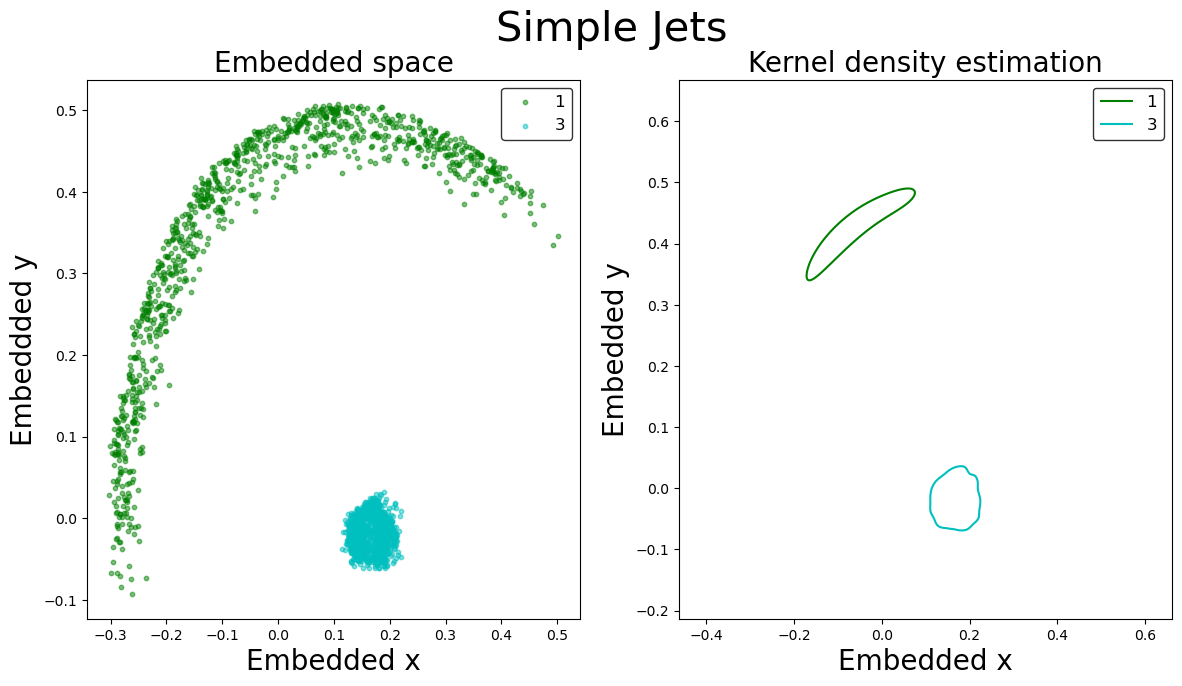

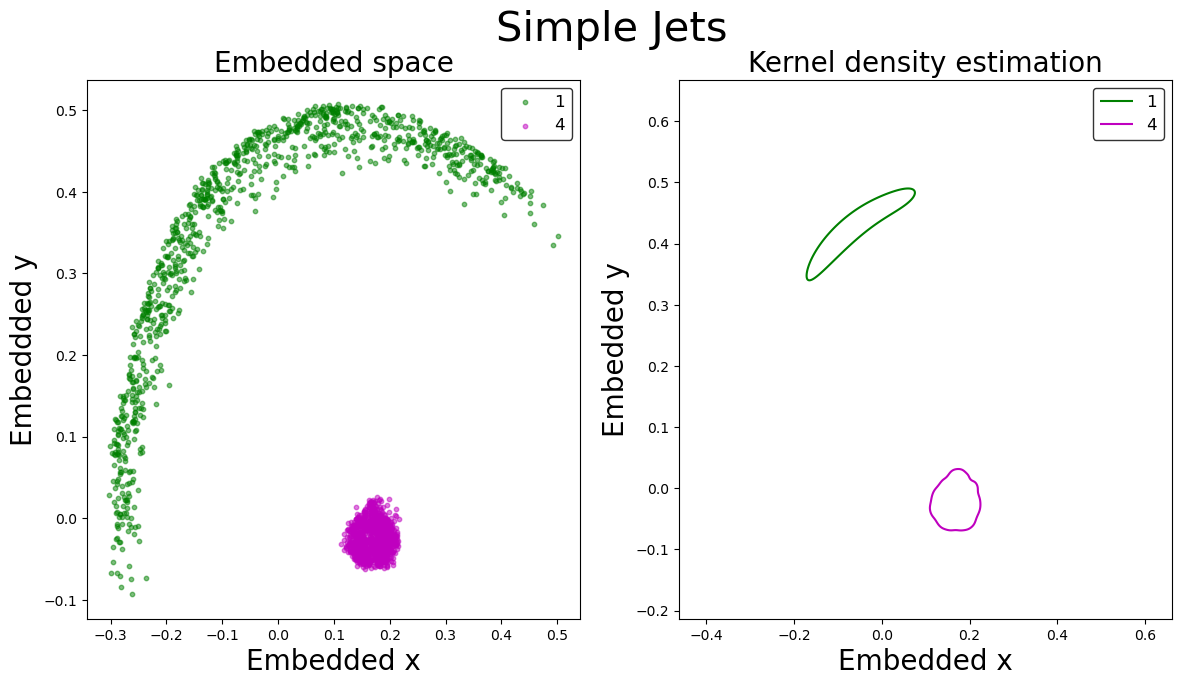

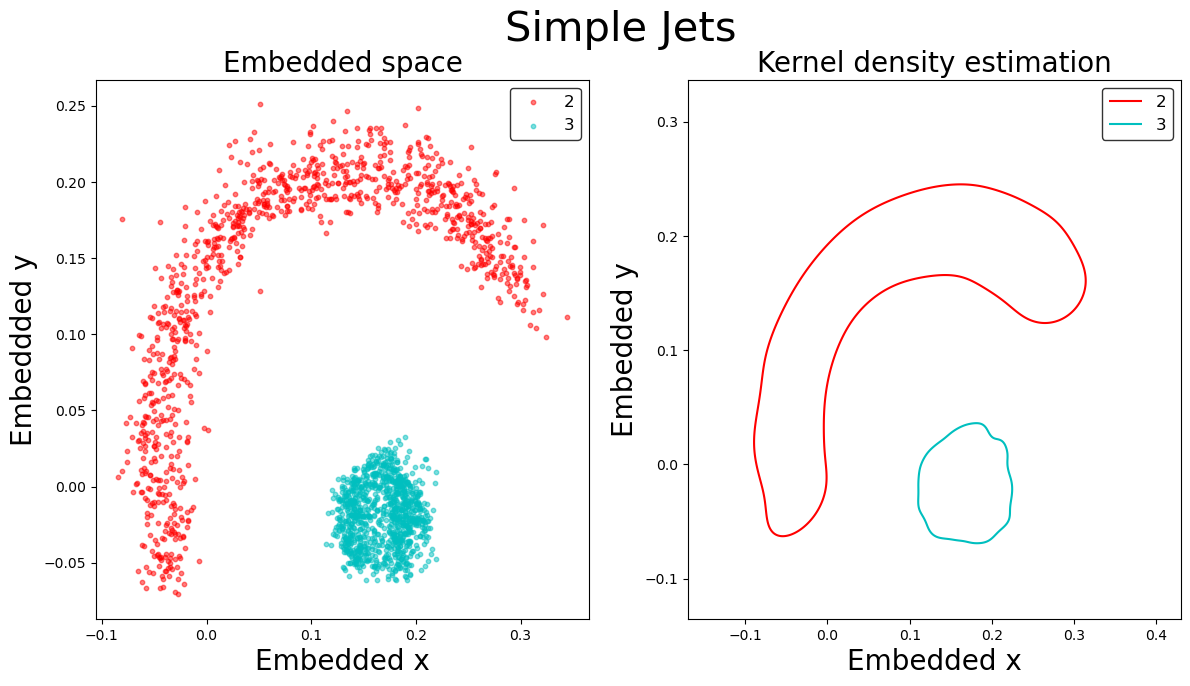

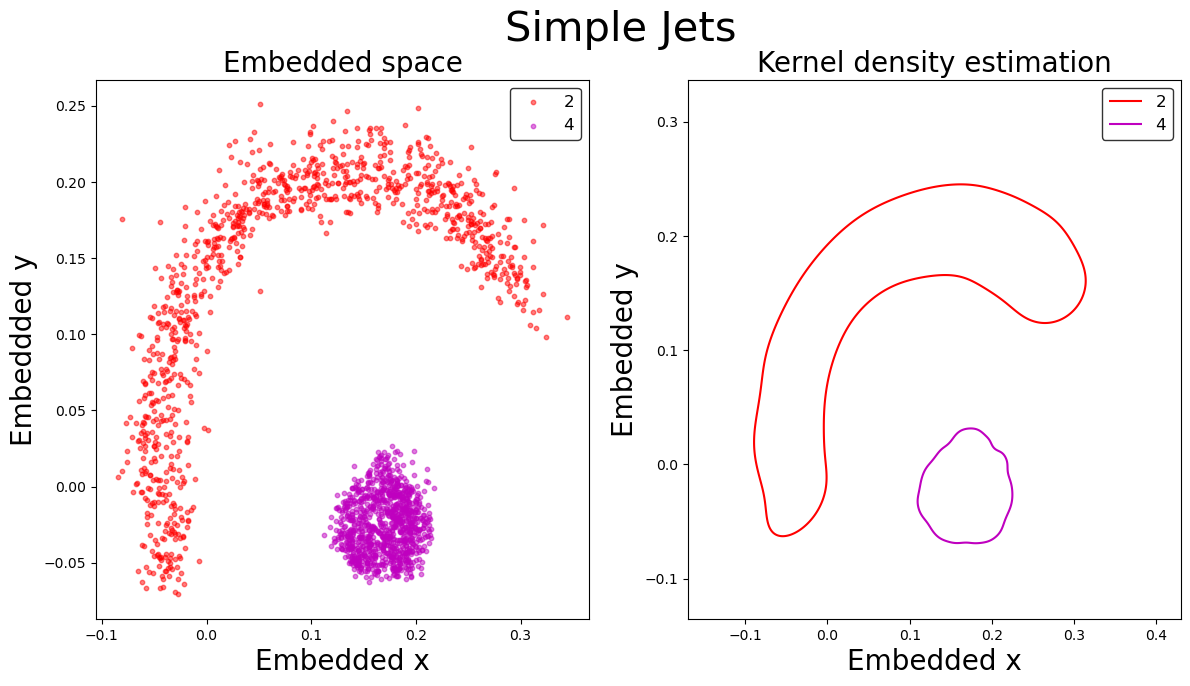

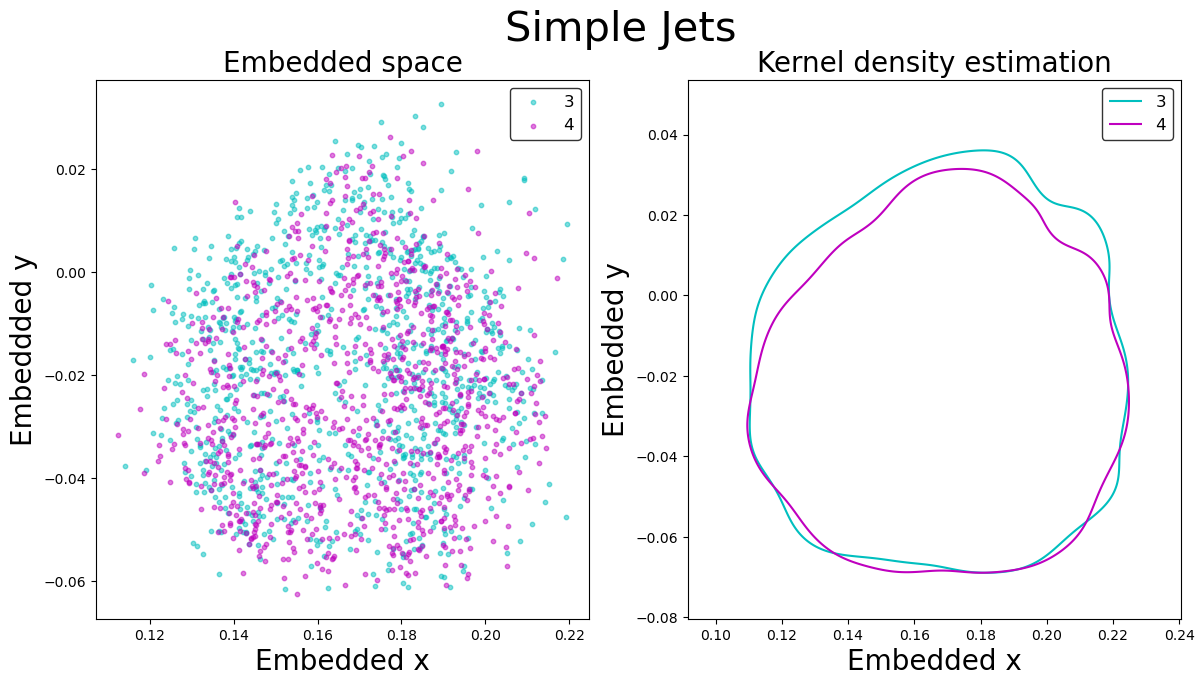

In [15]:
#------------------------------------------------------------------------------------PLOT
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [1,2,3,4]:
    for n_target in [1,2,3,4]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('Simple Jets', fontsize = 30)

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation', fontsize = 20)
            ax1_test.set_xlabel('Embedded x', fontsize = 20)
            ax1_test.set_ylabel('Embedded y', fontsize = 20)

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space', fontsize = 20)
            ax2_test.set_xlabel('Embedded x', fontsize = 20)
            ax2_test.set_ylabel('Embeddded y', fontsize = 20)

            for j in [n_bullet,n_target]:
                for i in torch.nonzero( targets_test == j)[:,0]:
                    ax2_test.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
                var.append(labels[j-1])
                col.append(colors[j-1])

            ax2_test.legend(var, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax2_test.transAxes)

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in torch.nonzero(targets_test == k)[:,0]:

                    X[l] = sample_emb_test[0][i]
                    l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                # kernel.set_bandwidth(bw_method=0.8)

                f = np.reshape(kernel(positions).T, xx.shape)

                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [10], colors=colors[k-1])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax1_test.transAxes)
            var, col, h = [], [], [] 
            fig_test.savefig('/home/gabrieleb/Plot/Jets/Real/KDE_MyLoss/KDE'+str([n_bullet,n_target])+'_sim.pdf', facecolor='w',pad_inches=0.3, transparent=True)
plt.show()

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [ ]:
fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedding.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [50]:
#plotting E_dist emb

E = torch.triu(torch.cdist(sample_emb_test[0], sample_emb_test[0], p = 2))
torch.save([E, targets_test],'/data/gabrieleb/data/Jets/E_dist_real_emb_transformer_sim_4D_s='+str(test.size(0)))

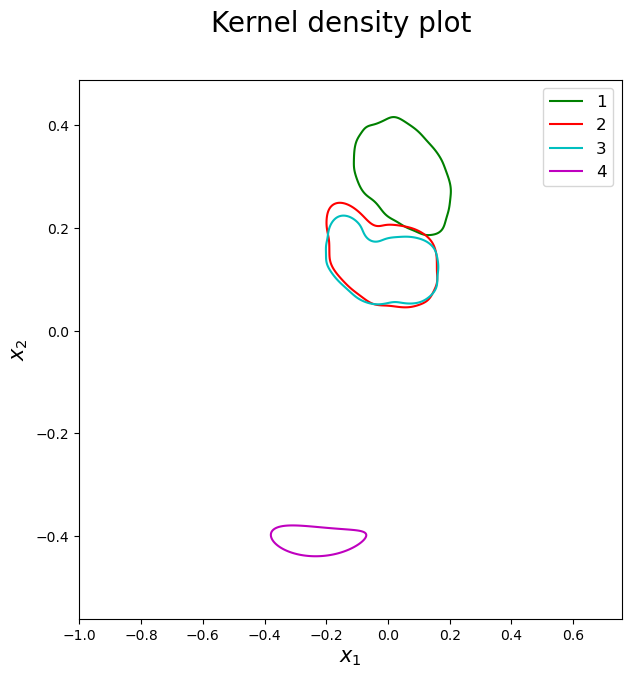

In [35]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('$x_1$', fontsize = 15)
ax.set_ylabel('$x_2$', fontsize = 15)

lab, h = [], []

for k in [1,2,3,4]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in torch.nonzero(targets_test == k)[:,0]:
        X[l] = sample_emb_test[0][i]
        l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    # kernel.set_bandwidth(bw_method=0.8)

    f = np.reshape(kernel(positions).T, xx.shape)

    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [5], colors = colors[k-1])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k-1])

ax.legend(h, lab, loc = 'best', fontsize = 12)
fig.savefig('/home/gabrieleb/Plot/Jets/Real/KDE_1234_myloss_Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

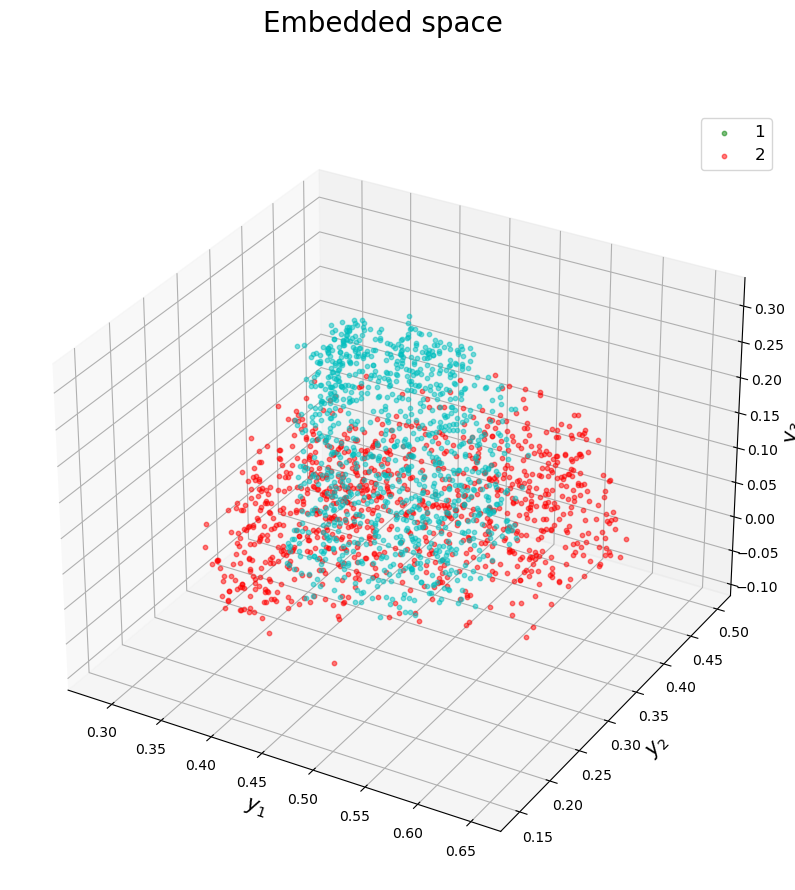

In [ ]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

# fig, ax = plt.subplots(1,1, figsize = (7,7))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('$y_1$', fontsize = 15)
ax.set_ylabel('$y_2$', fontsize = 15)
ax.set_zlabel('$y_3$', fontsize = 15)

for j in [4]:
    for i in torch.nonzero(targets_test == j)[:,0]:
        print(i)
        # ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
        ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), sample_emb_test[0][i][2].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
        
    var.append(labels[j-1])
    col.append(colors[j-1])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
# fig.savefig('/home/gabrieleb/Plot/Jets/Real/Embedded_1234_myloss_transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []